In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ExpSineSquared, DotProduct
import pandas as pd
from matplotlib import cm

plt.rcParams.update({'font.size': 12})
data_path = Path('data')

In [3]:
train_df = pd.read_csv(data_path / 'PLAsTiCC-2018' / 'training_set.csv')

In [4]:
obj_id_arr = np.unique(train_df['object_id'])

In [5]:
def get_timeseries(id):
    sub_df = train_df.loc[train_df['object_id'] == id]
    obj_dict = {}
    for i in range(6):
        band_sub_df = sub_df.loc[sub_df['passband'] == i]
        obj_dict[i] = {
            'mjd': band_sub_df['mjd'].values.tolist(),
            'flux': band_sub_df['flux'].values.tolist(),
            'flux_err': band_sub_df['flux_err'].values.tolist(), 
            'detected': band_sub_df['detected'].values.tolist()
        }
    return obj_dict

test = get_timeseries(745)
# train_dict = dict(zip(obj_id_arr, [get_timeseries(id) for id in obj_id_arr]))

test_id = np.random.choice(obj_id_arr, size=5, replace=False)
test_dict = dict(zip(test_id, [get_timeseries(id) for id in test_id]))


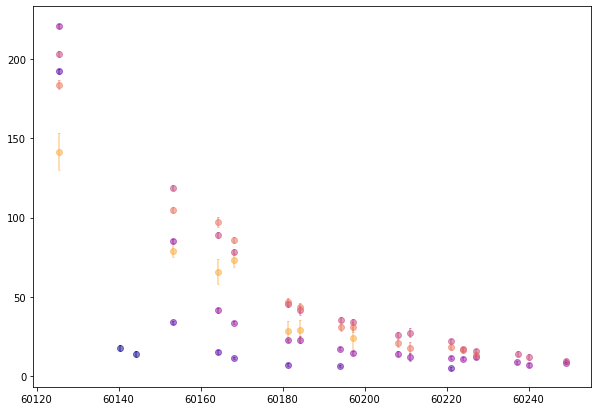

In [6]:
carr = np.linspace(0., 0.8, 6)
cmap = cm.get_cmap('plasma')

plt.figure(figsize=(10, 7))
for i in range(6):
    mask = np.asarray(test[i]['detected'], dtype=bool)
    plt.errorbar(
        np.asarray(test[i]['mjd'])[mask], np.asarray(test[i]['flux'])[mask], 
        yerr=np.asarray(test[i]['flux_err'])[mask],
        alpha=0.5, marker='o', capsize=1., ls='', color=cmap(carr[i])
    )

plt.show()

In [7]:
kern = 1.**2 * Matern(length_scale=10., length_scale_bounds=[10., 1000.], nu=2.5)
# kern = 1.**2 * ExpSineSquared(length_scale=4., periodicity=4., periodicity_bounds=[0.1, 1000]) + 1. * WhiteKernel(noise_level=1.)
# kern = 1. * DotProduct(sigma_0=5., sigma_0_bounds=[1., 100.])

def gpr_fit(id, band):
    data = get_timeseries(id)[band]
    mask = np.asarray(data['detected'], dtype=bool)
    if not np.sum(mask): 
        print(f'No detected observations for object {id}, band {i}.')
        return None
    
    t_obs = np.asarray(data['mjd'])# [mask]
    flux = np.asarray(data['flux'])# [mask]
    flux[mask == False] = 0.
    flux_err = np.asarray(data['flux_err'])# [mask}

    t0 = t_obs[np.argmax(flux)]
    t_obs -= t0

    gpr = GaussianProcessRegressor(kernel=kern, alpha=flux_err**2, normalize_y=False)
    gpr.fit(t_obs.reshape(-1, 1), flux.reshape(-1, 1))
    return gpr


In [8]:
t_gpr = np.linspace(-300., 200., 250)
model = gpr_fit(1124, 1)

data = get_timeseries(1124)[1]
mask = np.asarray(data['detected'], dtype=bool)
t_obs = np.asarray(data['mjd'])[mask]
flux = np.asarray(data['flux'])[mask]
flux_err = np.asarray(data['flux_err'])[mask]
t_obs_nd = np.asarray(data['mjd'])[~mask]
flux_nd = np.asarray(data['flux'])[~mask]
flux_err_nd = np.asarray(data['flux_err'])[~mask]
t0 = t_obs[np.argmax(flux)]
t_obs -= t0
t_obs_nd -= t0

pred, err = model.predict(t_gpr.reshape(-1, 1), return_std=True)
print(model.kernel_)


15**2 * Matern(length_scale=114, nu=2.5)


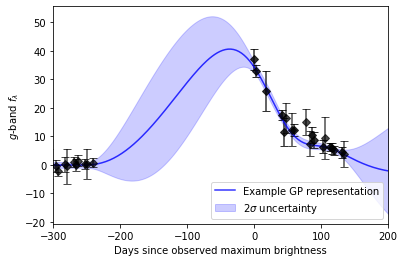

In [9]:
plt.figure(figsize=(6, 4))

plt.errorbar(
    t_obs, flux, yerr=1.96 * flux_err, color='black', marker='D', capsize=4., alpha=0.8, ls='',
)
plt.errorbar(
    t_obs_nd, flux_nd, yerr=1.96 * flux_err_nd, color='black', marker='D', capsize=4., alpha=0.7, ls=''
)
plt.plot(
    t_gpr, pred, alpha=0.8, color='blue', label='Example GP representation'
)
plt.fill_between(
    t_gpr, pred.T[0] - 1.96 * err, y2=pred.T[0] + 1.96 * err, color='blue', alpha=0.2,
    label=r'$2\sigma$ uncertainty'
)
plt.xlabel(r'Days since observed maximum brightness')
plt.ylabel(r'$\it{g}$-band $f_{\lambda}$')
plt.legend(loc='lower right')
plt.xlim([t_gpr[0], t_gpr[-1]])
# plt.title(r'Implicit Representation model $\mathcal{F} \approx \mathbf{F}$')
plt.savefig('gp.pdf', bbox_inches='tight')

plt.show()

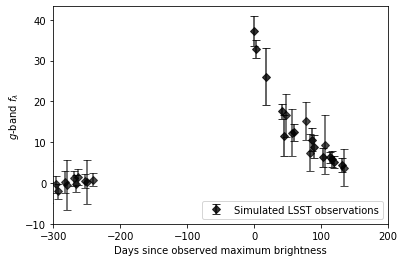

In [10]:
plt.figure(figsize=(6, 4))

plt.errorbar(
    t_obs, flux, yerr=1.96 * flux_err, color='black', marker='D', capsize=4., alpha=0.8, ls='',
    label='Simulated LSST observations'
)
plt.errorbar(
    t_obs_nd, flux_nd, yerr=1.96 * flux_err_nd, color='black', marker='D', capsize=4., alpha=0.7, ls=''
)
plt.xlabel(r'Days since observed maximum brightness')
plt.ylabel(r'$\it{g}$-band $f_{\lambda}$')
plt.legend(loc='lower right')
plt.xlim([t_gpr[0], t_gpr[-1]])
plt.savefig('data.pdf', bbox_inches='tight')
plt.show()

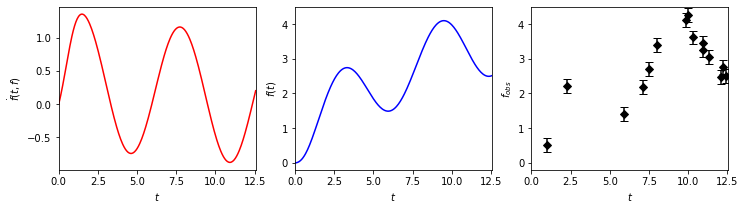

In [45]:
from scipy.integrate import odeint
from scipy.stats import norm

err_norm = norm(scale=0.2)

def dfdt(f, t):
    return np.sin(t) + f * np.exp(-f)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 3))

t = np.linspace(0., 4. * np.pi, 300)
f0 = 0.

f = odeint(dfdt, f0, t).T[0]

arg_obs = np.random.choice(np.asarray(range(300)), size=15, replace=False)
err_arr = err_norm.rvs(size=15)
f_obs = f[arg_obs] + err_arr
t_obs = t[arg_obs]
ax1.plot(t, np.sin(t) + f * np.exp(-f), color='red')
ax1.set_xlim([t[0], t[-1]])
ax2.plot(t, f, color='blue')
ax2.set_xlim([t[0], t[-1]])
ax3.errorbar(
    t_obs, f_obs, yerr=0.2, color='black', ls='', marker='D', capsize=4
)
ax3.set_xlim([t[0], t[-1]])
ax2.set_ylim([-0.2, 4.5])
ax3.set_ylim([-0.2, 4.5])
ax1.set_xlabel(r'$t$')
ax2.set_xlabel(r'$t$')
ax3.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\dot{f}(t, f)$')
ax2.set_ylabel(r'$f(t)$')
ax3.set_ylabel(r'$f_{obs}$')
plt.savefig('flow.pdf', bbox_inches='tight')
plt.show()


In [30]:
err_arr

array([-0.76552577,  1.25521376, -2.90444686, -2.61742486,  1.28790411,
        0.97499554,  0.98914766, -0.11410767,  0.35972974, -0.70457269,
        0.24738117, -0.51266448, -0.28843511, -1.22476181, -0.15894692])